Some things that I found helpful include
* Conv2D Layers
* MaxPool2D Layers
* Dropout Layers
* Batch-Normalization Layers
* Dense Layers
* ONE Flatten Layer
Load in the CIFAR10 Dataset: This should contain 60,000 32x32 pixel color images, 50k test and 10k train. An easy place to pull them in from

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Secret Sauce for Running on GPU if one is available: (I suggest running on colab for this reason)

In [ ]:
# Check the device name to confirm if GPU is assigned
import tensorflow as tf
print(tf.test.gpu_device_name())

# Get more details about the allocated GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7171165244119111062
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9612884442448385628
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import torch
import torchvision

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from keras.utils import to_categorical

In [ ]:
X_train = trainset.data/255
y_train = to_categorical(trainset.targets, 10)

X_test = testset.data/255
y_test = to_categorical(testset.targets, 10)

In [ ]:
trainset.data.shape

(50000, 32, 32, 3)

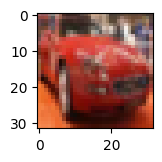

In [ ]:
plt.figure(figsize=[1.5,1.5])
plt.imshow(trainset.data[5])

In [ ]:
import keras
from keras import layers
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

l2_strength = 0.003
dropout_rate = .2

model = keras.Sequential([
    layers.Conv2D(32, (7,7), activation='relu', kernel_regularizer=l2(l2_strength), input_shape=(32,32,3)),
    layers.Dropout(dropout_rate),
    # BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(l2_strength)),
    layers.Dropout(dropout_rate),
    # BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(l2_strength)),
    layers.Dropout(dropout_rate),
    # BatchNormalization(),
    layers.Flatten(),
    layers.Dense(32, activation='tanh', kernel_regularizer=l2(l2_strength)),
    layers.Dropout(dropout_rate),
    # BatchNormalization(),
    layers.Dense(32, activation='tanh', kernel_regularizer=l2(l2_strength)),
    layers.Dropout(dropout_rate),
    # BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        4736      
                                                                 
 dropout (Dropout)           (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                   

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=1024,
                    validation_data=(X_test, y_test))

Epoch 1/100
49/49 [==============================] - 4s 36ms/step - loss: 2.7086 - val_loss: 2.5391
Epoch 2/100
49/49 [==============================] - 1s 27ms/step - loss: 2.4795 - val_loss: 2.4216
Epoch 3/100
49/49 [==============================] - 1s 27ms/step - loss: 2.3973 - val_loss: 2.3705
Epoch 4/100
49/49 [==============================] - 1s 30ms/step - loss: 2.3595 - val_loss: 2.3473
Epoch 5/100
49/49 [==============================] - 2s 32ms/step - loss: 2.3416 - val_loss: 2.3344
Epoch 6/100
49/49 [==============================] - 1s 30ms/step - loss: 2.3316 - val_loss: 2.3271
Epoch 7/100
49/49 [==============================] - 1s 29ms/step - loss: 2.3240 - val_loss: 2.3212
Epoch 8/100
49/49 [==============================] - 1s 29ms/step - loss: 2.3189 - val_loss: 2.3170
Epoch 9/100
49/49 [==============================] - 1s 29ms/step - loss: 2.3156 - val_loss: 2.3142
Epoch 10/100
49/49 [==============================] - 1s 29ms/step - loss: 2.3216 - val_loss: 2.3415

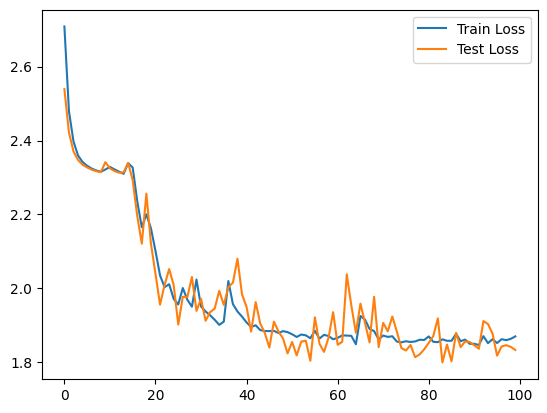

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

In [ ]:
y_pred = model.predict(X_test)

313/313 [==============================] - 2s 4ms/step


In [ ]:
np.mean(np.argmax(y_pred, 1) == np.argmax(y_test, 1))

0.3192

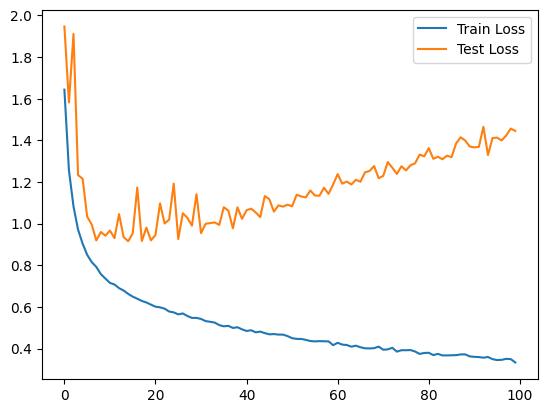

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

In [ ]:
import keras
from keras import layers
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

model = keras.Sequential([
    layers.Conv2D(32, (5,5), strides=(2,2), activation='relu', input_shape=(32,32,3), kernel_initializer='he_uniform'),
    BatchNormalization(),
    layers.Dropout(0.1),
    layers.Conv2D(32, (5,5), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    layers.Dropout(0.1),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    # # layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax')
])

model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy')

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        2432      
                                                                 
 batch_normalization_14 (Ba  (None, 14, 14, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 32)        25632     
                                                                 
 batch_normalization_15 (Ba  (None, 10, 10, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 10, 10, 32)      

In [ ]:
from keras.callbacks import ModelCheckpoint

# Set up the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',    # Path where the model will be saved
    monitor='val_loss',    # Save based on the validation loss
    verbose=1,             # Log message verbosity
    save_best_only=True,   # Only save the model if `val_loss` has improved
    mode='min',            # `min` mode means the callback focuses on minimizing `val_loss`
    save_freq='epoch')     # Save at the end of every epoch

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint])

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 1.7827
Epoch 1: val_loss improved from inf to 3.36394, saving model to best_model.keras
50/50 [==============================] - 5s 46ms/step - loss: 1.7827 - val_loss: 3.3639
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 1.4262
Epoch 2: val_loss improved from 3.36394 to 2.07981, saving model to best_model.keras
50/50 [==============================] - 1s 29ms/step - loss: 1.4252 - val_loss: 2.0798
Epoch 3/100
49/50 [============================>.] - ETA: 0s - loss: 1.2807
Epoch 3: val_loss improved from 2.07981 to 1.64327, saving model to best_model.keras
50/50 [==============================] - 1s 26ms/step - loss: 1.2803 - val_loss: 1.6433
Epoch 4/100
49/50 [============================>.] - ETA: 0s - loss: 1.1826
Epoch 4: val_loss improved from 1.64327 to 1.41626, saving model to best_model.keras
50/50 [==============================] - 1s 26ms/step - loss: 1.1834 - val_loss: 1.4163
Epoch 5/

In [ ]:
from keras.models import load_model

# Load the best model from the file
model = load_model('best_model.keras')

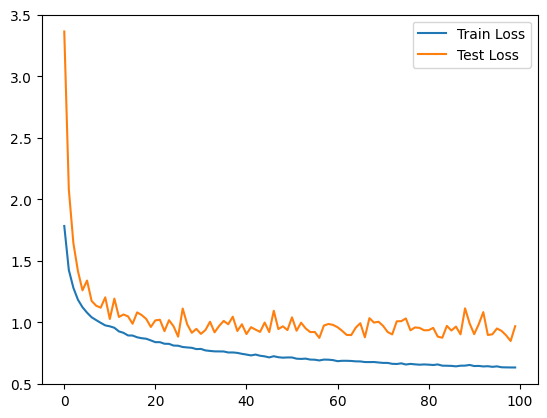

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

313/313 [==============================] - 1s 2ms/step


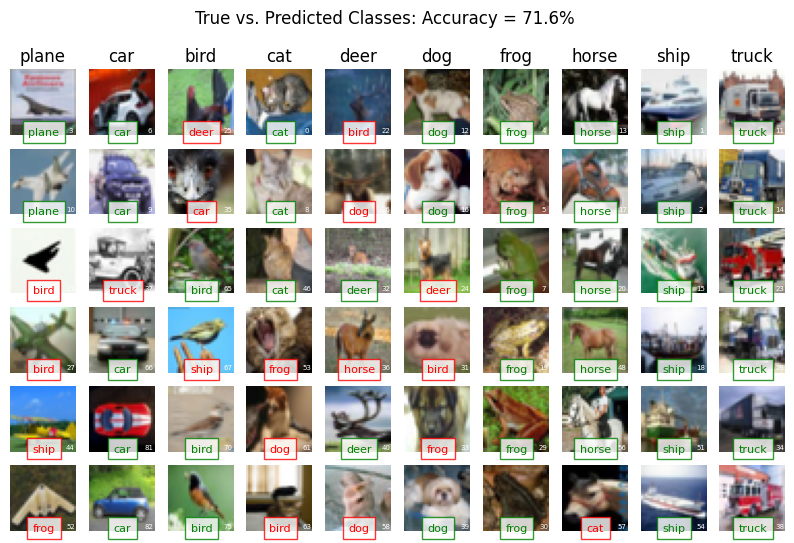

In [ ]:
# Use your model to make predictions HERE:
y_pred = model.predict(X_test)

correct_preds = np.argmax(y_pred, 1) == np.argmax(y_test, 1)

# Get the indices of the first k-occurrences of each class
k=6
sample_inds = [list(np.where(np.where(y_test)[1]==i)[0][:k]) for i in range(10)]

# For each class and occurance plot that image
plt.figure(figsize=[10,6])
for i, l in enumerate(sample_inds):
    for j, sample_index in enumerate(l):
        plt.subplot(k,10,10*j+i+1)
        plt.imshow(X_test[sample_index])
        # And annotate the image with the predicted class colored by correctness
        t = plt.text(16, 30, classes[np.argmax(y_pred[sample_index])], fontsize=8,
                     color= 'green' if correct_preds[sample_index] else 'r',
                     ha='center', va='center')
        t.set_bbox(dict(facecolor='white', alpha=0.8,
                        edgecolor='green' if correct_preds[sample_index] else 'r'))
        # Also print the sample index in the corner
        plt.text(29, 29, str(sample_index), color='w', fontsize=5,
                 ha='center', va='center')
        plt.axis('off')
        if j == 0:
            plt.title(classes[i])

plt.suptitle(f'True vs. Predicted Classes: Accuracy = {100*np.mean(correct_preds):.1f}%')
plt.show()

313/313 [==============================] - 1s 2ms/step


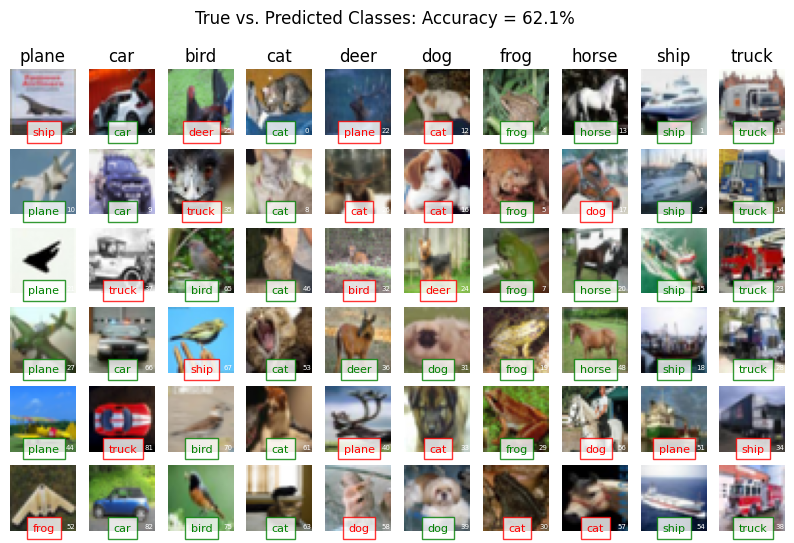

In [ ]:
# Use your model to make predictions HERE:
y_pred = model.predict(X_test)

correct_preds = np.argmax(y_pred, 1) == np.argmax(y_test, 1)

# Get the indices of the first k-occurrences of each class
k=6
sample_inds = [list(np.where(np.where(y_test)[1]==i)[0][:k]) for i in range(10)]

# For each class and occurance plot that image
plt.figure(figsize=[10,6])
for i, l in enumerate(sample_inds):
    for j, sample_index in enumerate(l):
        plt.subplot(k,10,10*j+i+1)
        plt.imshow(X_test[sample_index])
        # And annotate the image with the predicted class colored by correctness
        t = plt.text(16, 30, classes[np.argmax(y_pred[sample_index])], fontsize=8,
                     color= 'green' if correct_preds[sample_index] else 'r',
                     ha='center', va='center')
        t.set_bbox(dict(facecolor='white', alpha=0.8,
                        edgecolor='green' if correct_preds[sample_index] else 'r'))
        # Also print the sample index in the corner
        plt.text(29, 29, str(sample_index), color='w', fontsize=5,
                 ha='center', va='center')
        plt.axis('off')
        if j == 0:
            plt.title(classes[i])

plt.suptitle(f'True vs. Predicted Classes: Accuracy = {100*np.mean(correct_preds):.1f}%')
plt.show()